# 13. Sentiment Classification-sentiment140-B

In [1]:
#Libraries to import
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import plotly.offline as po
import plotly.graph_objs as pg
%matplotlib inline
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

<h3>Dataset description</h3>
<p>The given dataset contains text tweets which are around 1,600,000 tweets extracted using the Twitter API.The sentiment columns has two values 0 as negetive and 4 as positive which is able of detecting sentiments.</p>
<p>There are total of 6 columns and are descripted below. Later on we convert the output class labels as 0 and 1 for bilstm to train .</p>
<p>
<ol>1.sentiment: The polarity of the tweet (0 = negative, 4 = positive)</ol>
<ol>2.ids:  The id of the tweet </ol>
<ol>3.date: The date of the tweet </ol>
<ol>4.flag: The query value. </ol>
<ol>5.user: The user account that tweeted </ol>
<ol>6.text: The tweeted text</ol>
</p>

In [2]:
#Display the full text
pd.set_option('display.max_colwidth', None)

#Read the csv file.
data=pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin-1',header=None,names=["sentiment", "ids", "date", "flag", "user", "text"])
data.head()


,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [3]:
#Read the test csv
data_test=pd.read_csv("/content/testdata.manual.2009.06.14.csv", encoding='latin-1',header=None,names=["sentiment", "ids", "date", "flag", "user", "text"])
data_test.head()

,sentiment,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  498 non-null    int64 
 1   ids        498 non-null    int64 
 2   date       498 non-null    object
 3   flag       498 non-null    object
 4   user       498 non-null    object
 5   text       498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


<h3>Observation:</h3>
<p>There are total of 498 data points in the test data set.</p>

<h3>Objecive of the project</h3>
<p>NLP is a division of Computer Science where we make computer understand the semantic group of words,language translation and so on.In this project we develope Sequence models which can perform Sentimental Analysis to categorize tweets into Positive and Negetive</p>

# Data Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


<h3>Observation:</h3>
<p>There are total of 6 columns , among which there are no null values .2 are numerical features namely val and comment_id rest are categorical features. This dataframe utilized 73.2 MB od the memory.Further only 'sentiment' and 'text' fields are used for analysis and other fields dont have significant impact on sentiment and can be ignored.</p>

## Exploraray Data Analysis

In [6]:
print("Data  Size: ", len(data))

Data  Size:  1600000


In [7]:
#View the unique sentimental values (0-Neg and 4-Pos)
data['sentiment'].unique()

array([0, 4])

In [8]:
#form the dataset for analysis.
data = data[['sentiment','text']]
data_test = data_test[['sentiment','text']]

In [9]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [10]:
data_test.head()

,sentiment,text
0,4,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


<h3>1. Check if the population is balanaced or Imbalanced. (ie) are the negetive and positive tweets equal.</h3>

Count of sentiment: sentiment
0    800000
4    800000
Name: text, dtype: int64


[Text(0, 0, '-Ve'), Text(0, 0, '+Ve')]

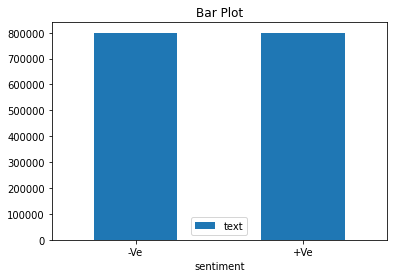

In [11]:
sent_count=data.groupby('sentiment').count()['text']
print("Count of sentiment:",sent_count)

data.groupby('sentiment').count().plot(kind='bar', title='Bar Plot',legend=True).set_xticklabels(['-Ve','+Ve'], rotation=0)

<h3>Observation:</h3>
<p>The training dataset is balanced for both positive and negetive reviews.</p>

In [12]:
#Run these when on google colab.
import nltk
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download(r'stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<h3>Observation:</h3>
<p>From the above bar plots we can see that , the dataset is balanced and over-sampling is not required for the dataset.Each has a value of 800000 values.</p>

<h3>2. Preprocessing of the tweets .</h3>
<p> Preprocessing is necessary has the tweets contains texts that have urls,username, emojis and remove non-alphabtes as they dont have any impact on classification of tweets .It also helps the model understand the sentiments better. If the user types smile emoji , based on regex we identify and convert into text like "smile".</p>
<p>Some of the steps followed for pre-processing are:</p>
<ol>1.Lower Case: tweet texts are converted into lower cases.</ol>
<ol>2.Replace URLS: Links containing keywords like 'http' or 'https'  we replace with empty string</ol>
<ol>3.Replace Usernames: Usernames start with @ they are replaced with empty string</ol>
<ol>4.Replace Consecutive letter: 3 or more consecutive letters are replaces with 2 .(Eg Hiiii to Hii)</ol>
<ol>5.Replace Emoji:replace with the emotion like 'smile'</ol>
<ol>6.Remove non-alphabets</ol>
<ol>7.remove stop words </ol>

In [13]:
import re
import nltk
from nltk.corpus import stopwords

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Stop words.
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preprocess_apply(tweet):

    tweet = tweet.lower()
    
    #Replace for consecutive words.
    tweet = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', tweet)
    
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(r"[8:=;]['`\-]?[)d]+", '<happy>', tweet)
    tweet = re.sub(r"[8:=;]['`\-]?\(+", '<dullface>', tweet)
    tweet = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', tweet)
    tweet = re.sub(r"[8:=;]['`\-]?p+", '<funnyface>', tweet)
    
    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    
    #remove stop words
    tweet = pattern.sub('', tweet)
    
    return tweet

In [14]:
#Preprocess the data
data['processed_text'] = data.text.apply(preprocess_apply)

In [15]:
#To view the processed text like for usernames,urls and emojis
data.head()

,sentiment,text,processed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",<user> <url> awww bummer shoulda got david carr third day <happy>
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,<user> dived many times ball managed save 50 rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",<user> behaving mad see


In [16]:
# Drop the text column in the dataset
data.drop(['text'], axis=1, inplace=True)

data

,sentiment,processed_text
0,0,<user> <url> awww bummer shoulda got david carr third day <happy>
1,0,upset update facebook texting might cry result school today also blah
2,0,<user> dived many times ball managed save 50 rest go bounds
3,0,whole body feels itchy like fire
4,0,<user> behaving mad see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,thewdb com cool hear old walt interviews <url>
1599997,4,ready mojo makeover ask details
1599998,4,happy 38th birthday boo alll time tupac amaru shakur


In [17]:
#renaming the processed_text to text without creating copy.
data.rename(columns={'processed_text': 'text'}, inplace=True)

In [18]:
data

,sentiment,text
0,0,<user> <url> awww bummer shoulda got david carr third day <happy>
1,0,upset update facebook texting might cry result school today also blah
2,0,<user> dived many times ball managed save 50 rest go bounds
3,0,whole body feels itchy like fire
4,0,<user> behaving mad see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,thewdb com cool hear old walt interviews <url>
1599997,4,ready mojo makeover ask details
1599998,4,happy 38th birthday boo alll time tupac amaru shakur


<h3>3. Exploraray Data Analysis:</h3>
<p>Plot various plots regarding sentimental analysis for  twitter data.</p>

<h3>3.1 Categorical Bar Plots</h3>

Number of heart emicons are 0
Number of happy emicons are 13331
Number of sad emicons are 2443
Number of neutral emicons are 9313
Number of lol emicons are 5052


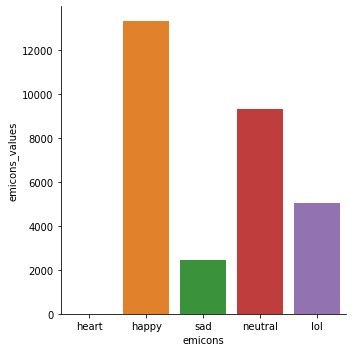

In [19]:
#View to see what emotion is more in the given dataset for the tweets

heart_emicon=data['text'].str.contains('<heart>').sum()
happy_emicon=data['text'].str.contains('<happy>').sum()
sad_emicon=data['text'].str.contains('<dullface>').sum()
neutral_emicon=data['text'].str.contains('<neutralface>').sum()
lol_emicon=data['text'].str.contains('<funnyface>').sum()

print("Number of heart emicons are",heart_emicon)
print("Number of happy emicons are",happy_emicon)
print("Number of sad emicons are",sad_emicon)
print("Number of neutral emicons are",neutral_emicon)
print("Number of lol emicons are",lol_emicon)

#Plotting categorical plots
emicons=["heart","happy","sad","neutral","lol"]
emicons_values=[heart_emicon,happy_emicon,sad_emicon,neutral_emicon,lol_emicon]
emicon_frame=pd.DataFrame()
emicon_frame['emicons'] = emicons
emicon_frame['emicons_values'] = emicons_values
axis=sns.catplot(x="emicons", y="emicons_values", data=emicon_frame, kind="bar")

<h3>Observation</h3>
<p>From the given dataset we can see that 'happy' emicons are widely used.</p>

<h3>3.2 Word Cloud for Tweets both positive and negetive(Train and Test)</h3>

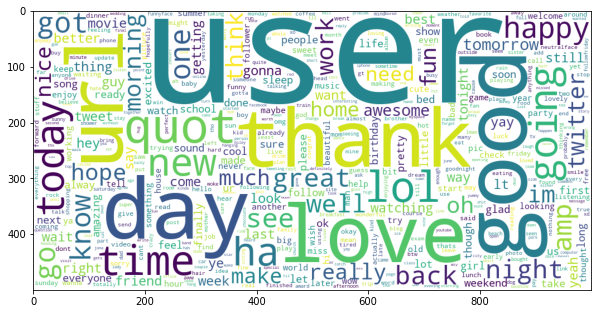

In [20]:
#Positive text  has what word the most
pos_data=data[data['sentiment']==4]
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,background_color='white',
              collocations=False).generate(" ".join(pos_data.text))
plt.figure(figsize = (10,10))
plt.imshow(wc)

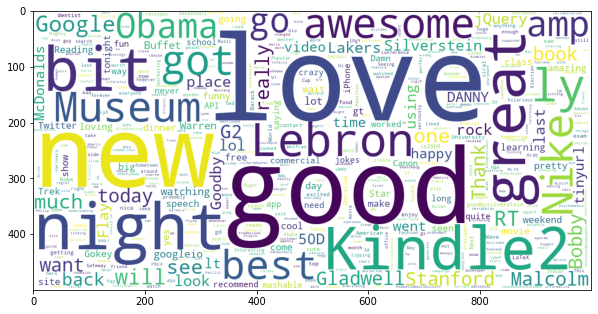

In [21]:
#Positive text  has what word the most
pos_data=data_test[data_test['sentiment']==4]
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,background_color='white',
              collocations=False).generate(" ".join(pos_data.text))
plt.figure(figsize = (10,10))
plt.imshow(wc)

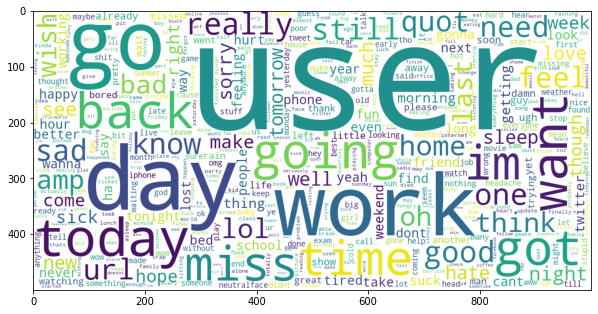

In [22]:
#Negetive text has what word the most.
neg_data=data[data['sentiment']==0]
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,background_color='white',collocations=False).generate(" ".join(neg_data.text))
plt.figure(figsize = (10,10))
plt.imshow(wc)

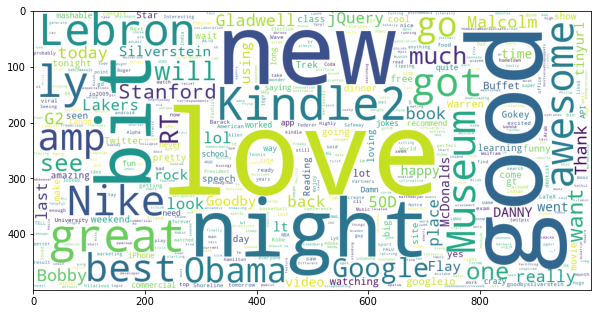

In [23]:
#Positive text  has what word the most
pos_data=data_test[data_test['sentiment']==4]
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,background_color='white',
              collocations=False).generate(" ".join(pos_data.text))
plt.figure(figsize = (10,10))
plt.imshow(wc)

<h3>Observation:</h3>
<p>Almost every text has 'user' keyword in them for both negetive and positive review. We can see that train and test data have almost same words. 'user' is absent in test data because the preprocessing is not performed on the test data.</p>

<h3>4.Forming the training and testing dataset </h3>
<p>Given csv are for training and testing the dataset.</p>

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np

#Here X is independent variable and Y is dependent. Sentiment depends on the twitter text.
X_train, Y_train = np.array(data['text']), np.array(data['sentiment'])

X_test, Y_test = np.array(data_test['text']), np.array(data_test['sentiment'])

print("\nNumber of training datasets:",X_train.shape)
print("\nNumber of testing datasets:",X_test.shape)



Number of training datasets: (1600000,)

Number of testing datasets: (498,)


<h3>5. Word2Vec model</h3>
<p>Word Embedding is the representation of document vocabulary.They are vector representations of particular word.Word2Vec has been developed by Google and is a word embeddings using shallow neural network.</p>

In [26]:
#library for word2vec
from gensim.models import Word2Vec
emb_dimen = 100
input_length = 70
vocab_length = 70000

# Creating Word2Vec training dataset.
Word2vec = list(map(lambda x: x.split(), X_train))

#parameters:
#training dataset:Word2vec
#Number of dimensions for Word2Vec to map:size:100
#Worker threads for parallism:workers:10
#Minimum count for pruning the internal dictionary:min_count:6
word2vec_model = Word2Vec(Word2vec,size=100,workers=10,min_count=6)

print("Word Length for the Word2vec Vocabs:", word2vec_model)

Word Length for the Word2vec Vocabs: Word2Vec(vocab=46872, size=100, alpha=0.025)


**Tokenization:**

Tokenization is a process of breaking the data into tokens . Here the words in sentence are split based on space.

In [27]:
#Tokenizing the Word2Vec
tokenizer = Tokenizer(filters="",lower=False) 
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length

In [28]:
#Embedding matrix creation.

embedding_matrix = np.zeros((vocab_length, emb_dimen))
print("Embedding Matrix Shape:", embedding_matrix.shape)

for word, token in tokenizer.word_index.items():
    #print(word,token)
    if word2vec_model.wv.__contains__(word):
        #For the embedding matrix from the word2vec
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)



Embedding Matrix Shape: (70000, 100)


In [29]:
#Padding makes the size of training and testing the same as the given length.

print("Input length",input_length)
print("Train-set length",X_train.shape)
print("Test-set length",X_test.shape)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)


Input length 70
Train-set length (1600000,)
Test-set length (498,)


In [30]:
#Building a Bi-lstm model
import tensorflow as tf
#Layers for Bilstm model:

#1.embeddinglayer : It converts the tokens into vector representation.Here we define the size of vocabulary and dimension of dense embedding and input data length.
#2.Bidirectional : It has the memory cell to learn the context of the words.
#4.Dense : Sigmoid layer to transfer the output between 0 or 1 classes (positve or negetive review.)
def bilstm_model():
    
    bilstm = tf.keras.Sequential()
    bilstm.add(tf.keras.layers.Embedding(input_dim = vocab_length,output_dim = emb_dimen,input_length=input_length))
    bilstm.add(tf.keras.layers.Bidirectional(LSTM(100, dropout=0.25,return_sequences=True)))
    bilstm.add(tf.keras.layers.Bidirectional(LSTM(100)))
    bilstm.add(tf.keras.layers.Dense(16, activation='relu'))
    bilstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))


    return bilstm

In [31]:
training_model = bilstm_model()

In [32]:
training_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           7000000   
                                                                 
 bidirectional (Bidirectiona  (None, 70, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                3216      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,404,833
Trainable params: 7,404,833
Non-

In [33]:
#Binary loss calculation.
training_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [34]:
#Sigmoid takes values between 0 and 1 only so 4 is converted to 1.
Y_train[Y_train>0] = 1
Y_test[Y_test>0]=1

In [35]:
#Train the model
model_lstm = training_model.fit(
    X_train, Y_train,
    batch_size=520,
    epochs=20,
    validation_split=0.1,
    verbose=1) 

Epoch 1/20
2770/2770 [==============================] - 156s 53ms/step - loss: 0.4847 - accuracy: 0.7606 - val_loss: 0.5178 - val_accuracy: 0.7592
Epoch 2/20
2770/2770 [==============================] - 146s 53ms/step - loss: 0.4451 - accuracy: 0.7903 - val_loss: 0.5239 - val_accuracy: 0.7498
Epoch 3/20
2770/2770 [==============================] - 147s 53ms/step - loss: 0.4330 - accuracy: 0.7967 - val_loss: 0.5848 - val_accuracy: 0.7109
Epoch 4/20
2770/2770 [==============================] - 146s 53ms/step - loss: 0.4236 - accuracy: 0.8017 - val_loss: 0.5621 - val_accuracy: 0.7270
Epoch 5/20
2770/2770 [==============================] - 147s 53ms/step - loss: 0.4169 - accuracy: 0.8053 - val_loss: 0.5538 - val_accuracy: 0.7422
Epoch 6/20
2770/2770 [==============================] - 146s 53ms/step - loss: 0.4109 - accuracy: 0.8079 - val_loss: 0.5871 - val_accuracy: 0.7196
Epoch 7/20
2770/2770 [==============================] - 146s 53ms/step - loss: 0.4055 - accuracy: 0.8112 - val_loss: 0

In [36]:
model_lstm.history.values

<function dict.values>

Observation

We can see that loss value is decreasing at every epoch and the accuracy increases and reached 80% above which is good.

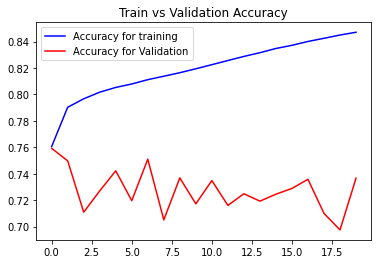

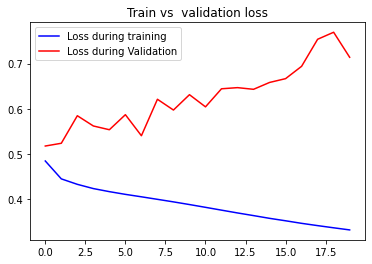

In [37]:
acc,  val_acc  = model_lstm.history['accuracy'], model_lstm.history['val_accuracy']
loss, val_loss = model_lstm.history['loss'], model_lstm.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Accuracy for training')
plt.plot(epochs, val_acc, 'r', label='Accuracy for Validation')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Loss during training')
plt.plot(epochs, val_loss, 'r', label='Loss during Validation')
plt.title('Train vs  validation loss')
plt.legend()

plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

def generate_confusion_matrix(y_pred, y_test):
     cf_matrix = confusion_matrix(y_test, y_pred)
     categories  = ['Negative','Positive']
     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
     print(np.asarray(labels).shape)
     print(cf_matrix.shape)
     labels = np.asarray(labels).reshape(2,2)

     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

     plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
     plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
     plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20) 

(4,)
(2, 2)


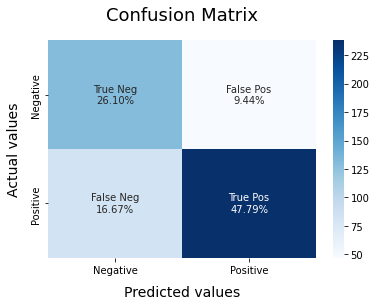

In [39]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

#Threshold as per sigmmoid 
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
generate_confusion_matrix(y_pred, Y_test)




(4,)
(2, 2)


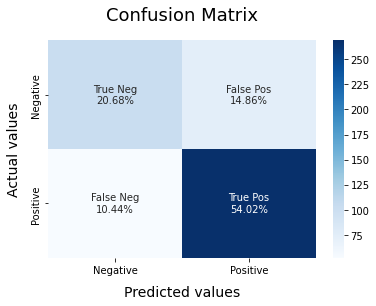

In [40]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

#Threshold varied to increases true pos and decrease false negetive.
y_pred = np.where(y_pred>=0.25, 1, 0)

# Printing out the Evaluation metrics. 
generate_confusion_matrix(y_pred, Y_test)

**Observation :**
After changing the threshold from 0.5 to 0.25 the True Positive rate increased .

In [41]:
# Print the evaluation metrics for the dataset.
print("Classification report is:",classification_report(Y_test, y_pred))

Classification report is:               precision    recall  f1-score   support

           0       0.66      0.58      0.62       177
           1       0.78      0.84      0.81       321

    accuracy                           0.75       498
   macro avg       0.72      0.71      0.72       498
weighted avg       0.74      0.75      0.74       498



In [42]:

import pickle

#word2vec
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

#tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

#Bilstm model
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets


INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets


Conclusion :

Therefore Bilstm performed well for bilstm with a accuracy greater than 80%. Bert can be used to achieve higher accuracy.